In [133]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import scipy

np.random.seed(42)

Hello there! This is my implementation of using QAOA to solve the weighted maxcut problem.

Based off of the [Pennylane demo](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html) and [Jack Ceroni's blog post](https://lucaman99.github.io/new_blog/2020/mar16.html).

This notebook assumes that you already know how QAOA works. I will not explain how QAOA works or why it works, but I will try to tell you what my code is doing.

To test out the code with different graphs, all you have to do is to change the variable `edges` to include the graph you want. Each edge is inputted individually in the form `(start_node, end_node, weight)`. Change all the weights to 1 for a non-weighted-graph.

All the user inputs are in one place -- they're all in the following codeblock. What's the point of having a generalized QAOA if the average person who doesn't know QC is unable to use it? As a sidenote, I was thinking of building a web-app where users can test the algorithm by inputting any graph they want. Similar to [something](https://sentiment.evanlin.ca/) my friend built - anyone online can run his trained natural language processing model.

In [134]:
## ALL USER INPUTS ## 

edges = [(0,1,0.7),(2,3,5),(3,0,4.5), (2,0,2.2), (0,3,2.5)] # Input the graph here. Coming up next: random graph generator?

## ADVANCED USER INPUTS ##
# For those familiar with the algorithm - if you want to tweak any hyperparameters ;)

num_layers = 4 # The number of layers to repeat our cost and mixer unitaries
num_reps = 100 # The number of repetitions of the circuit
num_iters = 100 # The number of iterations our optimizer will go through when optimizing parameters
init_params = 0.01 * np.random.rand(2, num_layers) # Initialize the parameters near zero. Generates array size 2, 4. 

We're going to calculate the number of nodes that are in the graph, so the user doesn't have to manually input it. We want to reduce the required effort of the useras much as possible.

The number of nodes is important information because is equal the number of wires (or qubits) that will be the circuit we construct.

In [135]:
nodes = []
for edge in edges:
    start_node = edge[0]
    end_node = edge[1]
    if (start_node not in nodes):
        nodes.append(start_node)
    if (end_node not in nodes):
        nodes.append(end_node)
num_nodes = len(nodes)
print(num_nodes)

4


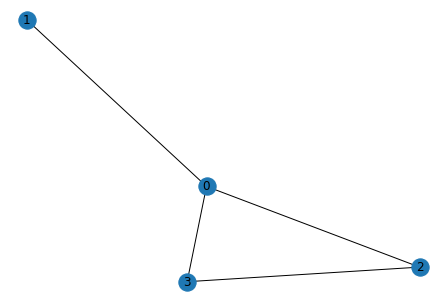

In [136]:
graph = nx.Graph() 
graph.add_nodes_from(nodes)
graph.add_weighted_edges_from(edges)
nx.draw(graph, with_labels=True)
plt.show() 

I will be using this graph to demonstrate this code. You can test out the algorithm with any other graph, by changing the graph in the User Inputs section.

In [137]:
# Mixer layer with parameter beta
def mixer_layer(beta):
    for wire in range(num_nodes):
        qml.RX(2 * beta, wires=wire)

# Cost layer with parameter gamma
def cost_layer(gamma):
    for edge in edges:
        wire1 = edge[0]
        wire2 = edge[1]
        weight = edge[2]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma*weight, wires=wire2) # Multiply gamma by the weight - this is one change from the unweighted maxcut code
        qml.CNOT(wires=[wire1, wire2])

In [138]:
# Defining a function to measure all qubits in the computational basis, because Pennylane doesn't seem to have one.
def comp_basis_measurement(wires):
    num_nodes = len(wires)
    return qml.Hermitian(np.diag(range(2 ** num_nodes)), wires=wires)

In [139]:
dev = qml.device("default.qubit", wires=num_nodes, analytic=True, shots=1)

In [140]:
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, num_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(num_nodes):
        qml.Hadamard(wires=wire)
    # Repeat the cost and mixer layers p times
    for layer in range(num_layers):
        cost_layer(gammas[layer])
        mixer_layer(betas[layer])
    measurement = qml.sample(comp_basis_measurement(range(num_nodes)))
    return measurement        

Phew, the quantum circuitry is over! Time for some post-measurement data processing.

Our circuit outputs the measurement as a decimal number, which we don't want. The measurement expressed as a bit string would be more helpful. This function will convert the decimal number into a binary number, or more specifically, an array of the bits (digits) of the binary number.

In [141]:
def decimal_to_binary(decimal): # future: abstract this function to take in length.
    binary_num = []
    
    def convert(decimal):
        if decimal >= 1:
            convert(decimal // 2)
            binary_num.append(decimal % 2)
    
    convert(decimal)
            
    for i in range(num_nodes + 1):
        if len(binary_num) < i:
            binary_num.insert(0, 0) # At beginning append 0
    
    return binary_num # Outputs array of the digits of the binary number

Now, we will define a function to measure the circuit `num_reps` number of times and output an array of measurements (bit strings).

In [142]:
def get_counts(params):   
    gammas = [params[0], params[2], params[4], params[6]]
    betas = [params[1], params[3], params[5], params[7]]
    
    # The results (bit strings) of running the circuit 100 times and getting 100 measurements
    bit_strings = []
    for i in range(0, num_reps):
        hold = int(circuit(gammas, betas, edge=None, num_layers=num_layers))
        bit_strings.append(hold) # This appends the integer from 0-15 (if 4 nodes) so it outputs the computational basis measurement in decimal. 

    counts = np.bincount(np.array(bit_strings)) # A 1x16 array that shows the frequency of each bitstring output
    most_freq_bit_string = np.argmax(counts) # Finds the most frequent bitstring

    return counts, bit_strings, most_freq_bit_string

Define a function to run `decimal_to_binary()` on each measurement (bit string) in the array `bit_strings`. This outputs an array of all 100 measurements in the form of individual bits.

In [143]:
def get_binary_bit_strings(bit_strings):
    bit_strings_binary = []
    for bit in bit_strings:
        bit_strings_binary.append(decimal_to_binary(bit))
    return bit_strings_binary

Now, we have our measurements in the format we want. This is the real deal of QAOA - where things start to get exciting. Next up is the cost function.

In [144]:
# Cost function

def cost_function(params):
    bit_strings = get_counts(params)[1]
    binary_bit_strings = get_binary_bit_strings(bit_strings)
    total_cost = 0
    for i in range(0, len(binary_bit_strings)): # Length of binary_bit_strings should be 100
        for edge in edges:
            start_node = edge[0]
            end_node = edge[1]
            weight = edge[2]
            # unweighted_cost = 0.5*( ( (1 - 2*binary_bit_strings[i][start_node]) * (1 - 2*binary_bit_strings[i][end_node]) ) - 1)
            # weighted_cost = unweighted_cost * weight
            weighted_cost = -1 * (weight * binary_bit_strings[i][start_node] * (1 - binary_bit_strings[i][end_node]) + weight * binary_bit_strings[i][end_node] * (1 - binary_bit_strings[i][start_node])) 
            total_cost += weighted_cost
        
    
    total_cost = float(total_cost) / 100

    print("Cost: "+str(total_cost))

    return total_cost

Next, we will optimize our parameters. We will use the COBYLA optimizer to reduce the cost function.

In [147]:
params = init_params

from scipy.optimize import minimize
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters}) 
# This optimizer changes our initialized params from a 2x4 array into a 1x8 array

print(f'Out: {out}')

Cost: -7.069000000000008
Cost: -7.472000000000011
Cost: -8.919000000000022
Cost: -8.027000000000015
Cost: -8.868000000000013
Cost: -8.68100000000002
Cost: -8.906000000000013
Cost: -8.256000000000018
Cost: -8.482000000000014
Cost: -7.425000000000009
Cost: -8.620000000000012
Cost: -8.422000000000013
Cost: -9.041000000000016
Cost: -6.309000000000003
Cost: -8.986000000000017
Cost: -8.945000000000018
Cost: -9.492000000000017
Cost: -9.928000000000011
Cost: -9.698000000000011
Cost: -9.383000000000015
Cost: -9.861000000000015
Cost: -5.360999999999999
Cost: -7.813000000000011
Cost: -11.277000000000019
Cost: -11.00600000000002
Cost: -11.178000000000013
Cost: -9.317000000000013
Cost: -10.693000000000016
Cost: -10.912000000000017
Cost: -11.168000000000017
Cost: -11.162000000000017
Cost: -11.682000000000015
Cost: -11.171000000000019
Cost: -11.126000000000019
Cost: -10.205000000000016
Cost: -11.583000000000018
Cost: -10.233000000000011
Cost: -11.008000000000015
Cost: -10.920000000000014
Cost: -11.33

In [148]:
optimal_params = out['x'] # This outputs a 2x4 array not a 1x8 
optimal_params_vector = []
for layer in range(len(optimal_params[0])): # Convert the 1x8 array into a 2x4 array
    optimal_params_vector.append(optimal_params[0][layer])
    optimal_params_vector.append(optimal_params[1][layer]) # optimal_params_vector is good
    
# optimal_params_vector is an array not a tensor 
final_bitstring = get_counts(optimal_params_vector)[1]

binary_bit_string = ''
for bit in decimal_to_binary(final_bitstring[2]): # This for loop gets the string version of the array binary_bit_string
        binary_bit_string += str(bit)

print(f'The answer to our weighted maxcut is: {final_bitstring[2]} or {binary_bit_string}')

The answer to our weighted maxcut is: 10 or 1010


Plot our data:

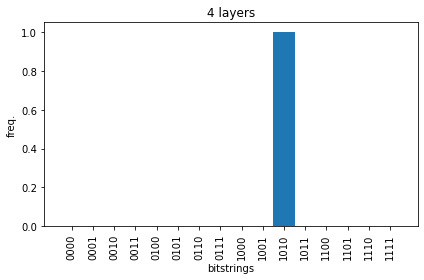

In [149]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

plt.title("4 layers")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(final_bitstring[1], bins=bins)

plt.tight_layout()
plt.show()

This is sort of success -  I got 1/2 of the answer 😅

Once we get our answer, how do we know that it is correct? We will calculate the expected cost (negative score) of each of our the possible bitstrings classically. If the bitstring with the smallest cost here is the bitstring that our circuit outputs, then our circuit got the correct answer.

In [150]:
for bitstring in range(2 ** num_nodes): # For each bitstring, we will calculate the cost classically without the quantum circuit.
    binary_bit_string = decimal_to_binary(bitstring) # Array type
    bit_string_cost = 0
    for edge in edges:
        start_node = edge[0]
        end_node = edge[1]
        weight = edge[2]
        weighted_cost = -1 * (weight * binary_bit_string[start_node] * (1 - binary_bit_string[end_node]) + weight * binary_bit_string[end_node] * (1 - binary_bit_string[start_node])) 
        bit_string_cost += weighted_cost
    
    binary_bit_string_2 = ''
    for bit in binary_bit_string: # Gets the string version of the array type binary_bit_string
            binary_bit_string_2 += str(bit)
    print(f'Cost of {binary_bit_string_2}: {bit_string_cost}')

Cost of 0000: 0.0
Cost of 0001: -12.0
Cost of 0010: -7.2
Cost of 0011: -9.2
Cost of 0100: -0.7
Cost of 0101: -12.7
Cost of 0110: -7.9
Cost of 0111: -9.9
Cost of 1000: -9.9
Cost of 1001: -7.9
Cost of 1010: -12.7
Cost of 1011: -0.7
Cost of 1100: -9.2
Cost of 1101: -7.2
Cost of 1110: -12.0
Cost of 1111: 0.0


The bit strings with the highest score are those with the lowest cost. In this case, they are 0101 and 1010. Our circuit also outputted 1010, therefore it got a correct answer.

Thanks for reading! I hope you have a great day :)